In [3]:
# To generate GIFs
#!pip install imageio
#!pip install git+https://github.com/tensorflow/docs
#!pip install tqdm

import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from keras.datasets import mnist
from IPython import display
from tqdm import tqdm

import keras
from keras.models import Model

#import tensorflow_docs.vis.embed as embed

#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import roc_curve, auc
#import seaborn as sns
#from sklearn.metrics import accuracy_score


Import & prep dataset

Training data shape:
 (60000, 28, 28, 1) 

Test data shape:
 (10000, 28, 28, 1) 

Training labels shape:
 (60000, 10) 

Test labels shape:
 (10000, 10)


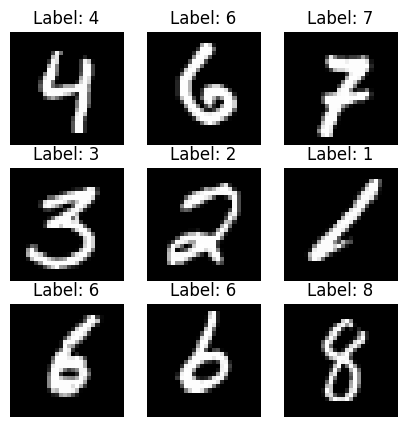

In [4]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

print("Training data shape:\n", train_data.shape, "\n")
print("Test data shape:\n", test_data.shape, "\n")
 
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
 
train_data /= 255 
test_data /= 255

train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

print("Training labels shape:\n", train_labels.shape, "\n")
print("Test labels shape:\n", test_labels.shape)

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

random_indices = np.random.choice(train_data.shape[0], 9, replace=False)
random_digits = train_data[random_indices]

plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(random_digits[i], cmap='gray')
    plt.title(f"Label: {np.argmax(train_labels[random_indices[i]])}")
    plt.axis('off')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

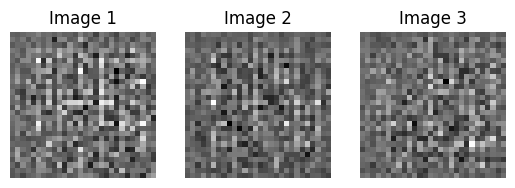

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()
generator.summary()
print("\n\n\n")

#plt.suptitle("Generated Images", fontsize=14)  
for i in range(3):
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

    plt.subplot(1, 3, i+1)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')
#plt.tight_layout()
plt.show()

Discriminator: Hier kann ein aufwändiges CNN rein. 

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

decision = discriminator(generated_image)
print("\n\n\n")
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    progress_bar = tqdm(dataset, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') #PROGRESS BAR!!!!

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 256, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

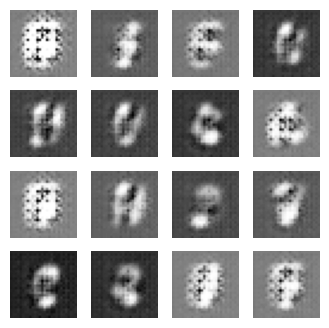

Time for epoch 4 is 322.325483083725 sec


Epoch 4/5:   0%|          | 0/235 [05:22<?, ?batch/s]


In [9]:
train(train_dataset, EPOCHS)

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

NameError: name 'EPOCHS' is not defined